In [49]:
import numpy as np

# generate data

In [50]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.

# In order to make the DEBUG more easy, I add the random seed for option 
def generate_data(dim = 10, num = 100, random_seed = -1):
    if random_seed != -1:
        np.random.seed(random_seed)
    x = np.random.normal(0, 10, [num, dim])

    if random_seed != -1:
        np.random.seed(random_seed)
    coef = np.random.uniform(-1, 1, [dim, 1])

    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)

    if random_seed != -1:
        np.random.seed(random_seed)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0

    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [51]:
# example
x, y, mr = generate_data(5, 100)
print(x[1:10, 1])
print(y[1:10])
print(mr)
print(type(x))




[ -7.74458648  -7.12996992  -2.83278552   9.59280265  -7.87267936
  -5.9525235    2.18658987  13.89747787 -10.80028404]
[[ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]]
0.04
<class 'numpy.ndarray'>


# write your model class

In [52]:
# you can do anything necessary about the model
def my_max(a, b):
    return a if a > b else b

def find_zero(a, b):
    return 0 if a == 0 else b

def array_max(a:np.ndarray, b:np.ndarray)->np.ndarray:
    func_ = np.frompyfunc(my_max, 2, 1)
    return(func_(a, b))

def array_find0(a:np.ndarray, b:np.ndarray) -> np.ndarray:
    func_ = np.frompyfunc(find_zero, 2, 1)
    return(func_(a, b))

class SVM1:
    def __init__(self):
        """
        You can add some other parameters, which I think is not necessary
        """

    def fit(self, X:np.ndarray, y:np.ndarray, gamma = 0.001, lr = 0.01, tol=1, max_times = 100, silent = True):
        """
        ---
        parameters:
        ---
            X: Data characteristics
            y: Data category
            gamma: Loss function parameter. Default 0.001
            lr: Learning rate. Default 0.01
            max_times: The maximum times of training iterations. Default 100
            tol: 梯度下降的阈值 Defalut 1
        """
        m, n = X.shape
        self.w = np.zeros((n + 1, 1))

        temp_1 = np.ones((m, 1))
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp_0 = np.zeros((m, 1))
        loss_list = []
        y_diag = np.diag(y.reshape(-1))

        if (silent):
            for times in range(max_times):
                xi = array_max(temp_0, 1 - (y_diag @ X_hat @ self.w))
                loss = 0.5 * (self.w.T @ self.w)[0][0] + gamma * (xi.sum())
                
                y_bar = array_find0(xi , y)

                delta_1 = self.w - gamma * (X_hat.T @ y_bar)
                
                if times >= 2 and abs(loss_list[-1] - loss) < tol:
                    loss_list.append(loss)
                    break

                self.w = self.w - lr * delta_1
                loss_list.append(loss)
        else:
            for times in range(max_times):
                xi = array_max(temp_0, 1 - (y_diag @ X_hat @ self.w))
                loss = 0.5 * (self.w.T @ self.w)[0][0] + gamma * (xi.sum())
                
                y_bar = array_find0(xi , y)

                delta_1 = self.w - gamma * (X_hat.T @ y_bar)
                
                if times >= 2 and abs(loss_list[-1] - loss) < tol:
                    loss_list.append(loss)
                    break

                if (times % 10 == 0):
                    print("Current times: {}, loss is {}".format(times, loss))

                self.w = self.w - lr * delta_1
                loss_list.append(loss)

        return loss_list, times
            

        
    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

        m, n = X.shape
        temp_1 = np.ones(m)
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp = X_hat @ self.w
        ans = []
        for i in range(m):
            if temp[i] > 0:
                ans.append(1)
            else:
                ans.append(-1)
        
        return np.array(ans).reshape(-1, 1)

In [53]:
# you can do anything necessary about the model
class SVM2:
    def __init__(self, X:np.ndarray, y:np.ndarray):
        """
        You can add some other parameters, which I think is not necessary
        """
        m, _ = X.shape
        self.X = X
        self.y = y
        self.alpha = np.zeros((m, 1))
        self.b = 0

    def _predict(self, X_index):
        """
        X_index in range(0, m)
        """
        alpha_y = self.alpha * y
        return (alpha_y @ self.X @ self.X[X_index, :].T)[0][0] + self.b
        

    def _error(self, X_index):
        return self._predict(X_index) - self.y[X_index, :]


    def _cut(self, a1_index, a2_index, a2_uncut, gamma):
        if self.y[a1_index] == self.y[a2_index]:
            low = max(0, self.alpha[a2_index, :] - self.alpha[a1_index, :])
            high = min(gamma, gamma + self.alpha[a2_index, :] - self.alpha[a1_index, :])
        else:
            low = max(0, self.alpha[a2_index, :] + self.alpha[a1_index, :] - gamma)
            high = min(gamma, self.alpha[a2_index, :] + self.alpha[a1_index, :])
        
        if a2_uncut > high:
            return high
        elif a2_uncut < low:
            return low
        return a2_uncut


    def _solve_alpha(self, a1_index, a2_index):
        alpha_y = self.alpha * y

        eta = self.X[a1_index, :].T @ self.X[a1_index, :] + \
              self.X[a2_index, :].T @ self.X[a2_index, :] - \
              2 * self.X[a1_index, :].T @ self.X[a2_index, :]

        if eta > 0:
            a2_uncut = self.alpha[a2_index, :] + self.y[a2_index, :] * \
                    (self._error(a1_index) - self._error(a2_index)) / eta
        else:
            raise "Not solved yet"
        
        alpha2_new = self._predict(a1_index, a2_index, a2_uncut)
        self.alpha[a1_index, :] = self.alpha[a1_index, :] + self.y[a1_index, :] * \
                                  self.y[a2_index, :] * (self.alpha[a2_index, :] - \
                                  alpha2_new )
        self.alpha[a2_index, :] = alpha2_new



    def fit(self, gamma = 0.001, lr = 0.01, tol=1, max_times = 100, silent = True):
        """
        Fit the coefficients via your methods
        """
        m, n = self.X.shape

        loss_list = []

        

        for times in range(max_times):
            alpha_y = self.alpha * self.y
            loss = self.alpha.sum() - 0.5 * (alpha_y.T @ self.X @ self.X.T @ alpha_y)[0][0]





            
            if times >= 2 and abs(loss_list[-1] - loss) < tol:
                loss_list.append(loss)
                break

            loss_list.append(loss)


        return loss_list, times


    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

        m, n = X.shape
        pass
        


# construct and train your models

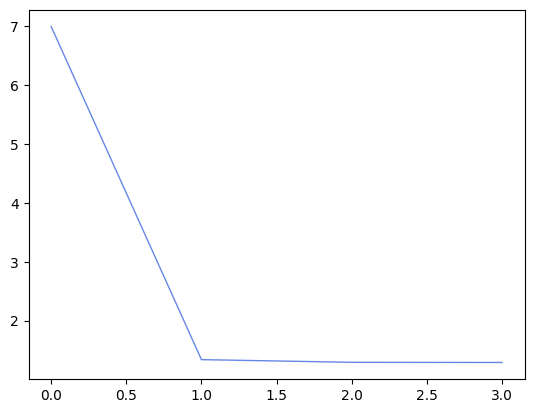

In [54]:
# generate data
X_data, y_data, mislabel = generate_data(dim=20, num=10000) 

# split data
def random_Split_data(X: np.ndarray, y:np.ndarray, rate = 0.7, random_seed: int = -1):
    data: np.ndarray = np.hstack((X, y))
    m, n = data.shape
    if random_seed != -1:
        np.random.seed(abs(random_seed))
    np.random.shuffle(data)
    
    row_split = int(m * rate)
    X_train = data[0: row_split, 0: -1]
    y_train = data[0: row_split, -1: ]
    X_test = data[row_split: m, 0: -1]
    y_test = data[row_split: m, -1: ]
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, rate=0.7)


# constrcut model and train (remember record time)
model1 = SVM1() 
# loss_list, times = model1.fit(X_train, y_train, gamma = 0.1, lr = 0.001, tol=1, max_times=100)
loss_list, times = model1.fit(X_train, y_train, tol=1e-2)
# print(model1.w)

# print(times)
# print(loss_list)




import matplotlib.pyplot as plt
def show(times, loss, color = '#4169E1', start=0, end=1500):
    x_axis_data = list(range(times + 1))[start:end]
    y_axis_data = loss[start:end]
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)


show(times, loss_list)


# predict and compare your results

In [55]:
# make prediction

def model_cmp(y_pre:np.ndarray, y_test:np.ndarray):
    # y should be in shape m x 1
    corr = 0
    sum = 0
    m, n = y_pre.shape
    
    for i in range(m):
        if y_pre[i] == y_test[i]:
            corr += 1
        sum += 1
    return corr/sum

# pred = model1.predict()

# compared with answer

# compare each methods
# print(X_test.shape)
pre = model1.predict(X_test)
print(pre.shape)
print(model_cmp(pre, y_test))


(3000, 1)
0.9543333333333334


In [56]:
# Calculate the model accuracy on average

from sklearn import svm

def model_accuracy_ave(model:str = '1', dim = 20, num = 10000, devide_rate = 0.7, total_time = 50):   # all possible parameters

    model_list = ['1', '2', 'skl']
    assert model in model_list, "unknown model: {}".format(model)

    sum = 0

    if model == '1':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM1() 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            sum = sum + model_cmp(pred, y_test)
            # print(model_cmp(pred, y_test))

    elif model == '2':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM2() 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            sum += model_cmp(pred, y_test)

    elif model == 'skl':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = svm.SVC(kernel='linear')
            model.fit(X_train, y_train)
            pred = model.predict(X_test).reshape(-1, 1)

            sum += model_cmp(pred, y_test)
            # print(model_cmp(pred, y_test))



    return sum/total_time

print("Model_{}:Ave={}".format('1', model_accuracy_ave(model='1')))
print("Model_{}:Ave={}".format('skl', model_accuracy_ave(model='1')))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\19043\AppData\Local\Temp\ipykernel_12928\2587058151.py", line 51, in <module>
    print("Model_{}:Ave={}".format('1', model_accuracy_ave(model='1')))
  File "C:\Users\19043\AppData\Local\Temp\ipykernel_12928\2587058151.py", line 14, in model_accuracy_ave
    X_data, y_data, mislabel = generate_data(dim, num)
  File "C:\Users\19043\AppData\Local\Temp\ipykernel_12928\3835947147.py", line -1, in generate_data
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 1997, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "d:\Python\lib\site-packages\IPython\core\ultratb.py", line 1112, in structured_traceback
    return Formatted